# 7.2 Bayesian Classifier based on Normal Distribution

In this second notebook of the object recognition chapter we will explore a popular statistical classifiers, the Bayesian ones. These methods are based on the idea that, given a number of features characterizing an object (the famous vector $\mathbf{x}$), the Bayes' rule can be used to predict its class. Recall the Bayes' rule: $\\[10pt]$

<center>
<img src="./images/bayes2.png">
</center>

In this way, Bayesian classifiers build probabilistic (statistical) models of the features according to certain training data, and use them to classify new objects. 

In this notebook, will explain:
- how (Naïve) Bayesian classifiers work (<a href="#721">section 7.2.1</a>) and, 
- specifically, how to classify feature vectors supposing that they follow a normal distribution (<a href="#722">section 7.2.2</a>).

## Problem context - Traffic sign recognition

In the previous notebook, *AliquindoiCars* contacted us looking for a TSR technique to be integrated into a self-driving car. They provided us with some segmented images of traffic signs that their autonomous cars captured during test drivings. These images are located in `images/circles/` containing circled signs, `images/triangles` containing signs having triangular shapes and `images/squares` containing signs having square shapes.$\\[3pt]$

<img src="./images/signs.jpg" width="400">$\\[3pt]$

Previously, we extracted a feature vector from each image using Hu moments. Now, we will train a classifier using the feature vectors we saved the in previous notebook. For classification, there are many methods we can apply, such as [kNN algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [random forest](https://en.wikipedia.org/wiki/Random_forest), etc. In this notebook, we will explore and use a classical one, the Naïve Bayes classifier!

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import scipy.interpolate
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

images_path = './images/'
import sys
sys.path.append("..")
from utils.PlotEllipse import PlotEllipse

### 7.2.1 (Naïve) Bayesian classifier <a id="721"></a>

The simplest case of these classifiers is the **Naïve Bayesian** one, which considers the strong (naïve) independence assumption that the input features are conditionally independent of each other given the object class. That is, for example, if we are using compactness and extent to describe objects, this classifier assumes that the value for both features is not related if the object class is known, i.e. circle. For the visual system in our previous notebook, which is in charge of recognizing objects in a kitchen, this means that if it knows that an object is a spoon, then its compactness would be unrelated with its extent (we could not say anything about its possible extent given a certain compactness, for example). 

In a general case with an arbitrary number of features $n$, the Bayes' rule can be written as:

$$P(C|x_1,\dots,x_n)= \frac{P(x_1,\dots,x_n|C)P(C)}{P(x_1,\dots,x_n)}$$

if the following naïve conditional assumption:

$$P(x_i|C,x_1,\dots,x_{i-1},x_{i+1},\dots,x_n)=P(x_i|C)$$

is considered for each feature $i$, then the rule can be simplified to:

$$P(C|x_1,\dots,x_n)=\frac{P(C)\prod_{i=1}^n P(x_i|C)}{P(x_1,\dots,x_n)}$$

Given that $P(x_1,\dots,x_n)$ is constant for a certain input, and that we are looking for the class that has the highest posterior probability, the following classification rule is considered:

$$P(C|x_1,\dots,x_n) \propto P(C) \prod_{i=1}^{n} P(x_i|C)$$

$$\hat{C}= arg\,\underset{C}max  P(C) \prod_{i=1}^{n} P(x_i|C)$$

Summarizing, having a set of features describing an object $\mathbf{x} = [x_1, x_2, x_3, \ldots, x_n]^T$ and a set of possible belonging classes $C = [C_1, C_2, C_3, \ldots, C_n]$, the Bayesian classifier assigns $\mathbf{x}$ to the class $C_i$ that has the highest posterior probability $P(C_i/x)$ (the more probable, the less probability of making a mistake). This is called a **MAP** (Maximum A Posteriori) prediction.

Considering the following joint probability distribution $P(C,\mathbf{x})$ (in this case $\textbf{x}$ contains just one variable):$\\[3pt]$

In [ ]:
x = np.array([0, 1, 2, 3])
pC1_given_x = np.array([0.3, 0.4, 0.8, 0.9])
pC2_given_y = np.array([0.7, 0.6, 0.2, 0.1])

x_new = np.linspace(0, 3, 300)
a_BSpline = scipy.interpolate.make_interp_spline(x, pC1_given_x, bc_type="natural")
b_BSpline = scipy.interpolate.make_interp_spline(x, pC2_given_y, bc_type="natural")
pC1_given_x_new = a_BSpline(x_new)
pC2_given_y_new = b_BSpline(x_new)

plt.plot(x_new, pC1_given_x_new, label='p(C1|x)')
plt.plot(x_new, pC2_given_y_new, label='p(C2|x)')
plt.plot([0.48,0.48],[0, 0.687],'g'); plt.plot(0.48,0.689,'og', label="p(C1|x=0.5)")
plt.plot([0.52,0.52],[0, 0.32],'r'); plt.plot(0.52,0.315,'or', label="p(C2|x=0.5)")

plt.ylabel('P(C,x)')
plt.xlabel('x_1')
plt.ylim([0,1])
plt.xlim([0,3])
plt.legend();

this MAP classification corresponds to assign the object to the class $C_i$ with the highest value. Since such an object is characterized by $x=x_1=0.5$, it is assigned to $C_2$ (assuming equal prior probability for each class), the category with highest $P(C|x=x_1)$ value. 

Depending on the application, it is convenient to consider a *rejection region*, where none probability is high enough and no decision is made (e.g. $P(C_1|x) = P(C_2|x) = 0.5$). The following code illustrates this, where a probability threshold $\theta$ defining such a region:$\\[3pt]$

In [ ]:
plt.plot(x_new, pC1_given_x_new, label='p(C1|x)')
plt.plot(x_new, pC2_given_y_new, label='p(C2|x)')

plt.ylabel('P(C,x)')
plt.xlabel('x_1')
plt.ylim([0,1])
plt.xlim([0,3])
plt.legend();

theta = 0.1 # threshold

plt.plot([0, 3],[0.5+theta, 0.5+theta],'g--')
plt.plot([0, 3],[0.5-theta, 0.5-theta],'g--')
plt.plot([1, 1],[0, 0.6],'g')
plt.plot([1.5, 1.5],[0, 0.6],'g')
plt.text(1.1, 0.1, 'Rejection \n region');

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now that you have notions about the rejection region, **answer the following questions**:

- Which class would an object with `x_1=0.5` belong to?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Which class would an object with `x_1=1.2` belong to?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Would the threshold theta be the same in any application?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

### Building discriminant functions

In the same way as we built linear and generalized discriminant functions in the previous notebook, those functions can be also defined to design a Bayesian classifier. For that, the goal is to obtain a discriminant function $d_i(x)$ for each class $C_i$, such that $d_i(x) \gt d_j(x)$ whenever $P(C_i|x) \gt P(C_j|x)$. Let's design them step by step!

From the Bayes' rule we have that :$\\[5pt]$

$$d_k(x) = P(C_k|\mathbf{x}) = \frac{p(\mathbf{x}|C_k)P(C_k)}{P(\mathbf{x})}\\[5pt]$$

This is, Bayes' rule defines a way to compute the posterior probability $P(C_k|\mathbf{x})$ of a feature vector $\mathbf{x}$ for each class $C_k$. We can further simplify this function:$\\[5pt]$

$$
\begin{eqnarray}
&d_k(x) &= P(C_k/\mathbf{x}) = \frac{p(\mathbf{x}|C_k)P(C_k)}{P(\mathbf{x})} 
\\
{P(\mathbf{x})\text{ is a constant value }\forall k} \Big\Downarrow
\\ 
\hspace{0.2cm}&d_k(x) &= p(\mathbf{x}|C_k)P(C_k)
\\
\max \ln(f(\mathbf{x})) = \max f(\mathbf{x}) \Big\Downarrow
\\
&d_k(x) &= \ln p(\mathbf{x}|C_k) + \ln P(C_k)
\\
\text{If } P(C_k) = P(C_j)\; \forall j,k  \Big\Downarrow
\\
&d_k(x) &= lnp(\mathbf{x}|C_k)
\end{eqnarray}
$$

The resulting formulation is also called **MLE (Maximum log-Likelihood Estimation)**.

### 7.2.2 Naive Bayesian classifier for normal distribution <a id="722"></a>

The different Naïve Bayesian Classifiers differ in the probability distribution considered for modeling $P(x_i|C)$. In this section we will cover **Normal distribution based ones**, which suppose that input features follow the probability density function of a Gaussian distribution:$\\[5pt]$

$$p(\mathbf{x}|C_i) = \large{\frac{1}{(2\pi)^{n/2}|\Sigma^i|^{1/2}}}
e^{-\frac{1}{2}(\mathbf{x}-\mu^i)^T\Sigma_i^{-1}(\mathbf{x}-\mu^i)}\\[5pt]$$

so two set of parameters are considered:$\\[5pt]$

- A mean vector for each class: $\mathbf{\mu}=[\mu_1 \mu_2 \dots \mu_f \dots \mu_n]^T$
- A covariance matrix for each class:
$\hspace{5pt}
\small
\Sigma = E[(\mathbf{x}-\mathbf{\mu}) \cdot (\mathbf{x}-\mathbf{\mu})^T]
=
\begin{bmatrix}
\sigma_{11} & \cdots & \sigma_{1f} & \cdots & \sigma_{1n} \\
\vdots & & \vdots & &  \vdots \\
\sigma_{n1} & \cdots & \sigma_{nf} & \cdots & \sigma_{nn}
\end{bmatrix}
=
\underbrace{\begin{bmatrix}
\sigma_{11} & \cdots & 0 & \cdots & 0 \\
\vdots & & \vdots & &  \vdots \\
0 & \cdots & 0 & \cdots & \sigma_{nn}
\end{bmatrix}}_{\text{Independence assumption (Naïve Bayes)}}
$

The simplification of the covariance matrix can be done by assuming independence (not correlation) among features, that is, the assumption done by Naïve Bayes!

The following code is just a review about how a Gaussian distribution with two variables depends on its two parameters $\mathbf{\mu}$ and $\Sigma$. Feel free to change such parameters and experience their influence!

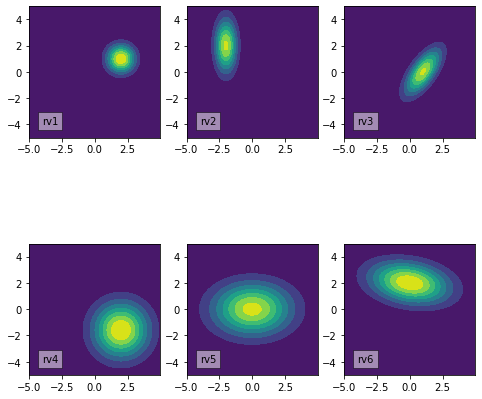

In [2]:
def plot_2d_gaussian(fig, rv, x, y, pos, position):
    """ Plot 2d contours of a 3D gaussian   
    """
    label = "rv" + str(position)
    position = str(23)+str(position)
    ax = fig.add_subplot(int(position))
    ax.contourf(x, y, rv.pdf(pos))    
    ax.text(-4,-4,label,bbox=dict(facecolor='white', alpha=0.5))
    ax.set_aspect('equal')

from scipy.stats import multivariate_normal
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

# Define 6 different Gaussian distributions 
mean1 = np.array([2.0, 1.0])
covar1 = np.array([[0.5, 0.0],[0.0, 0.5]])
rv1 = multivariate_normal(mean1, covar1)

mean2 = np.array([-2.0, 2.0])
covar2 = np.array([[0.3, 0.0],[0.0, 1.8]])
rv2 = multivariate_normal(mean2, covar2)

mean3 = np.array([1.0, 0.0])
covar3 = np.array([[0.8, 0.7],[0.7, 1.3]])
rv3 = multivariate_normal(mean3, covar3)

mean4 = np.array([2.0, -1.6])
covar4 = np.array([[2.0, 0.0],[0.0, 2.0]])
rv4 = multivariate_normal(mean4, covar4)

mean5 = np.array([0.0, 0.0])
covar5 = np.array([[4.0, 0.0],[0.0, 1.8]])
rv5 = multivariate_normal(mean5, covar5)

mean6 = np.array([0.0, 2.0])
covar6 = np.array([[3.9, -0.5],[-0.5, 1.1]])
rv6 = multivariate_normal(mean6, covar6)

# Show the contours fo the 3D gaussians
fig = plt.figure()
plot_2d_gaussian(fig,rv1,x,y,pos,1)
plot_2d_gaussian(fig,rv2,x,y,pos,2)
plot_2d_gaussian(fig,rv3,x,y,pos,3)
plot_2d_gaussian(fig,rv4,x,y,pos,4)
plot_2d_gaussian(fig,rv5,x,y,pos,5)
plot_2d_gaussian(fig,rv6,x,y,pos,6)

### Designing the discriminant function

It is time to see how we could define the discriminant function $d_k(\mathbf{x})$ for this classifier:

$$
\begin{eqnarray}
d_k(\mathbf{x}) &=& 
\ln P(C_k) + \ln p(\mathbf{x}|C_k) = \ln P(C_k) + \ln \frac{1}{(2\pi)^{n/2}|\Sigma^k|^{1/2}}e^{-\frac{1}{2}\overbrace{\color{blue}{(\mathbf{x}-\mu^k)^T\Sigma_k^{-1}\mathbf{x}-\mu^k)}}^{\text{Squared Mahalanobis distance}}}\\[7pt]
    &=& 
\ln P(C_k) - \ln 2\pi^{n/2} - \ln |\Sigma^k|^{1/2} - \frac{1}{2} \color{blue}{D_k^2(x)}\\[7pt]
    &=& 
\ln P(C_k) - \frac{1}{2}\left[\underbrace{n \ln 2\pi}_{\text{constant}} +  \ln |\Sigma^k| + D_k^2(x)\right] \\[7pt]
  &=&
\ln P(C_k) - \frac{1}{2}\left[\ln |\Sigma^k| + D_k^2(x)\right]\\[7pt]
\end{eqnarray}
\\[8pt]$$

We can see that the resulting **discriminant function is quadratic**:

$$\small
d_k(\mathbf{x}) 
= 
ln\ P(C_k) - \underbrace{ \frac{1}{2} \left[ ln\ |\Sigma^k| + \mu^{kT} (\Sigma^k)^{-1} \mu^k \right]}_{\text{Independent term}} 
+
\underbrace{\mathbf{x}^T (\Sigma^k)^{-1}\mathbf{\mu}^k}_{\text{linear term}} 
-
\frac{1}{2}\underbrace{ \mathbf{x}^T (\Sigma^k)^{-1}\mathbf{x}}_{\text{Quadratic term}}
$$

Visually, the **division boundaries are parabolas**:

<img src="./images/visual_normal_bayes.png">$\\[3pt]$

### **<span style="color:green"><b><i>ASSIGNMENT 1a: Training the classifier</i></b></span>**

Now, we are going to implement this Naïve Bayes classifier for normal distributions **using the Hu moments** computed in the previous exercise.

The first step for training such classifier is computing the weights' matrix of the discriminant function. In this case, it depends on the **mean** ($\bf{\mu}$, dimension $(2,)$) and **covariance matrix** ($\Sigma$, dimension $(2,2)$), which can be retrieved from the training data through MLE. 

In the previous notebook we proved that our TSR problem can be solved using only the first and second Hu moments. In this one **your first task** is:

- to load the firsts two Hu moments for the images from each class which, as commented, was computed in previous notebook (you can use [`np.load()`](https://numpy.org/doc/stable/reference/generated/numpy.load.html?highlight=load#numpy.load)). 
- Then, **compute the mean** (or centroid) and **covariance matrix** for each class. You can compute the covariance matrix of a set of points using [`np.cov()`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html).

In [ ]:
# Assignment 1a
#
# Load first 2 Hu moments of each class 
train_triangles = np.load("./data/hu_triangles.npy")[:,:2].T
train_circles = np.load("./data/hu_circles.npy")[:,:2].T
train_squares = np.load("./data/hu_squares.npy")[:,:2].T

# Compute covariance matrices
cov_triangles = np.cov(train_triangles)
cov_circles = np.cov(train_circles)
cov_squares = np.cov(train_squares)

# Compute means
mean_triangles = None
mean_circles = None
mean_squares = None

print ('cov_triangles = \n' + str(cov_triangles))
print ('cov_circles = \n' + str(cov_circles))
print ('cov_squares = \n' + str(cov_squares))
print ('mean_triangles = ' + str(mean_triangles))
print ('mean_circles = ' + str(mean_circles))
print ('mean_squares = ' + str(mean_squares))

<span style="color:blue;">Expected output:</span>
```
cov_triangles = 
[[1.17603861e-06 2.24894396e-07]
 [2.24894396e-07 8.80708956e-08]]
cov_circles = 
[[1.02189926e-07 3.33231869e-08]
 [3.33231869e-08 1.09259042e-08]]
cov_squares = 
[[1.61508686e-06 5.21788207e-07]
 [5.21788207e-07 1.70838002e-07]]
mean_triangles = [0.19254439 0.00034407]
mean_circles = [1.59537533e-01 9.98702969e-05]
mean_squares = [0.16720802 0.00026462]
```

### **<span style="color:green"><b><i>ASSIGNMENT 1b: Defining the discriminant function</i></b></span>**

Your **next task** is to develop a method, named `discriminant_function()`, that computes the discriminant function for each class $d_k(x)$. The inputs have to be:

- `features`: feature vector of dimension n (number of features, 2 in our problem).
- `mu`: mean vector of the class k.
- `cov`: covariance matrix with shape (n,n) of the class k.
- `prior`: prior probability of class k.

The method should evaluate (then return) the discriminant function.

In [ ]:
# Assignment 1b
#
def discriminant_function(features, mu, cov, prior):
    """ Evaluates the discriminant function d(x)
    
        Args:
            features: feature vector of dimension n
            mu: mean vector of the class of which is being computed the probability
            cov: covariance matrix with shape (n,n) of the class
            prior: prior probability of class k

        Returns:
            dx: result of discriminant function
    """
    covinv = np.linalg.inv(cov) # Auxiliar variable
    dx = None # You can divide this computation in as many lines as you need
    
    return dx


**You can try** your function with the following test:

In [ ]:
f = np.array([0.5, 0.6])
mu = np.array([0.7, 0.9])
cov = np.array([[0.7, 0.3],[0.3, 0.9]])
prior = 0.5
d = discriminant_function(f, mu, cov, prior)

print ('d = ' + str(d))

<span style="color:blue;">Expected output:</span>
```
d = -0.4433874441813701
```

### **<span style="color:green"><b><i>ASSIGNMENT 1c: Testing the classifier</i></b></span>**

For testing our brand new classifier, we are going to classify some new images and check the results. *Note that the discriminant function is the logarithm of a probability, not a probability itself (values can be positive and negatives, but the result of the max function is the same)*.

**What to do?** 
- Complete the auxiliary function `classify_image()` that:
    1. computes the Hu moments of a testing image `sign_image`, and   
    2. uses the discriminant function of each class to retrieve the highest output value. The class returning such a value would be the assigned one! $\\[10pt]$
- After completing such a function, in the code cell below it, call it for the `test_circle.png`, `test_square.png` and `test_triangle.png` images in order to classify them. 

*We assume that there is no prior information about any class, so $P(C_i) = P(C_j)\; \forall i,j$. This can be interpreted as: while driving, we see the same number of circle, square and triangle shaped road signs.*


In [ ]:
# Assignment 1c
#
def image_moments(region):
    """ Compute moments of the external contour in a binary image.   
    
        Args:
            region: Binary image
                    
        Returns: 
            moments: dictionary containing all moments of the region
    """   
    
    # Get external contour
    contours,_ = cv2.findContours(region,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_NONE)
    cnt = contours[0]
    
    # Compute moments
    moments = cv2.moments(cnt)
    
    return moments

In [ ]:
def classify_image(sign_image):
    """ Classify a traffic sign image by its shape using a bayesian classifier   
    
        Args:
            sign_image: Binarized image
    """   
    
    # Compute Hu moments
    moments = image_moments(sign_image)
    hu = cv2.HuMoments(None).flatten()[None:None]
    
    # Classify circle test image
    prior = 1/3
    triangle = discriminant_function(None,None,None,None)
    circle = discriminant_function(None,None,None,None)
    square = discriminant_function(None,None,None,None)
    
    # Search the maximum
    classification = max([None,None,None])
    
    if classification == triangle:
        print("The sign is a triangle\n")
    elif classification == circle:
        print("The sign is a circle\n")
    else:
        print("The sign is a square\n")        
    
    return hu

In [ ]:
# Read images
test_circle = cv2.imread(images_path + "test_circle.png", 0)
test_triangle = cv2.imread(images_path + "test_triangle.png", 0)
test_square = cv2.imread(images_path + "test_square.png", 0)

# Classify them
print("Circle: ")
moments_circle = classify_image(None)
print("Triangle: ")
moments_triangle = classify_image(None)
print("Square: ")
moments_square = classify_image(None)

# Create figure
fig, ax = plt.subplots()
plt.axis([0.158, 0.197, -0.02, 0.02])

# Plot hu moments
plt.plot(train_triangles[0,:],train_triangles[1,:],'go')
plt.plot(train_circles[0,:],train_circles[1,:],'ro')
plt.plot(train_squares[0,:],train_squares[1,:],'bo')
plt.xlabel('x_1')
plt.ylabel('x_2')

# Plot testing data
plt.plot(moments_circle[0],moments_circle[1],'*m',markersize=12)
plt.plot(moments_triangle[0],moments_triangle[1],'*m',markersize=12)
plt.plot(moments_square[0],moments_square[1],'*m',markersize=12);

### **<span style="color:green"><b><i>ASSIGNMENT 1d: Analyzing covariances</i></b></span>**

Finally, we can see how this classifier divides the feature space showing the computed covariance ellipses. **You have to** complete the following code cell to make it works, showing the covariance ellipses of each class.

In [ ]:
# Create figure
fig, ax = plt.subplots()
plt.axis([0.14, 0.2, -0.03, 0.03])

# Plot hu moments
plt.plot(train_triangles[0,:],train_triangles[1,:],'go')
plt.plot(train_circles[0,:],train_circles[1,:],'ro')
plt.plot(train_squares[0,:],train_squares[1,:],'bo')

# Plot ellipses representing covariance matrices
PlotEllipse(fig, ax, np.vstack(None), None, 15, color='black')
PlotEllipse(fig, ax, np.vstack(None), None, 15, color='black')
PlotEllipse(fig, ax, np.vstack(None), None, 15, color='black')

fig.canvas.draw()

### Simplification of the Naïve classifier

The classifier at hand can be simplified if the Euclidean distance is considered instead of the Mahalanobis one. This can be achieved using isotropic covariance matrices:


$$\Sigma^k = \Sigma = \sigma^2 \cdot I = \sigma^2 \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix}$$

In this way, decision boundaries are lines, and covariances are spherical. This is called a **natural classifier**:

<img src="./images/natural_classifier.png" width="500"><center><i>Example of feature space with 3 classes characterized by Gaussian distributions with isotropic covariances. Black lines are decision boundaries.</i></center>$\\[3pt]$

In this case, the discriminant function can be simplified, and the quadratic term disappears:$\\[6pt]$

$$d_k(x) = -(\mathbf{x-\mu^k})^T(\mathbf{x-\mu^k}) = -||\mathbf{x-\mu^k}||^2\\[6pt]$$

### **<span style="color:green"><b><i>ASSIGNMENT 2: Playing with isotropic covariance matrices</i></b></span>**


**What to do?** Repeat the previous steps but using isotropic covariance matrices. Recall that [`np.eye()`](https://numpy.org/doc/stable/reference/generated/numpy.eye.html) defines an identity matrix. 

In [ ]:
# Assignment 2
#
def discriminant_function_isotropic(features, mu):
    """ Evaluates the discriminant function of a naive Bayes clasifier using isotropic covariances
    
        Args:
            features: feature vector of dimension n
            mu: mean vector of the class of which is being computed the probability

        Returns:
            dx: result of discriminant function
    """
    dx = None
    return dx

In [ ]:
def classify_image_isotropic(sign_image):
    """ Classify a traffic sign image by its shape using a bayesian classifier   
    
        Args:
            sign_image: Binarized image
    """   
    
    # Compute Hu moments
    moments = image_moments(sign_image)
    hu = cv2.HuMoments(None).flatten()[None:None]
    
    # Classify circle test image
    triangle = discriminant_function_isotropic(None,None)
    circle = discriminant_function_isotropic(None,None)
    square = discriminant_function_isotropic(None,None)
    
    # Search the maximum
    classification = max([None,None,None])
    
    if classification == triangle:
        print("The sign is a triangle\n")
    elif classification == circle:
        print("The sign is a circle\n")
    else:
        print("The sign is a square\n")

In [ ]:
# Read images
test_circle = cv2.imread(images_path + "test_circle.png", 0)
test_triangle = cv2.imread(images_path + "test_triangle.png", 0)
test_square = cv2.imread(images_path + "test_square.png", 0)

# Classify them
print("Circle: ")
classify_image_isotropic(None)
print("Triangle: ")
classify_image_isotropic(None)
print("Square: ")
classify_image_isotropic(None)

**Complete the following code** to observe the isotropic covariance matrices. 

In [ ]:
# Create figure
fig, ax = plt.subplots()
plt.axis([0.14, 0.2, -0.03, 0.03])

# Plot hu moments
plt.plot(train_triangles[0,:],train_triangles[1,:],'go')
plt.plot(train_circles[0,:],train_circles[1,:],'ro')
plt.plot(train_squares[0,:],train_squares[1,:],'bo')

# Plot ellipses representing covariance matrices
PlotEllipse(fig, ax, np.vstack(None), None, 0.003, color='black')
PlotEllipse(fig, ax, np.vstack(None), None, 0.003, color='black')
PlotEllipse(fig, ax, np.vstack(None), None, 0.003, color='black')

fig.canvas.draw()

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now that you are an expert concerning the Naïve Bayesian classifier, **answer the following questions**:

- Considering the classifier that you implemented in assignment 1c, to which class would be assigned an object with `x_1=0.17` and `x_2=-0.01`? And considering the one in assignment 2?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

- What are the pros and cons of using isotropic covariances?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- In what type of problems could isotropic matrices be used?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- In your opinion, is it worth to consider a Bayes classifier when dealing with this problem? In which situations could this classifier show its potential?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

## Conclusion

Awesome! You now know how to design a classifier for previously segmented and characterized objects. Note that for more complex shapes, you can use the **7 Hu moments instead of the two that we used**. We reduced their number just for visualization and simplicity purposes.

In this notebook you have learned to:

- construct a Naïve Bayesian classifier and apply it to a real problem where features follow a normal distribution,
- build a simplified classifier where isotropic covariances are assumed, and
- improve a classifier (if needed) using rejection regions.